Computes the null model statistics

In [1]:
using Pkg
Pkg.activate("../../env/.")
Pkg.instantiate()

  Activating project at `~/Documents/analogous_neural/env`


In [2]:
include("../../src/analogous_bars.jl")
include("../../src/Eirene_var.jl")
using .analogous_bars
using .Eirene_var
using DelimitedFiles
using HDF5
using Plots
using FileIO
using Random

WebIO._IJuliaInit()

# Load data

In [3]:
using Distributed
addprocs(5)
@everywhere include("../../src/analogous_stats.jl")
@everywhere using .analogous_stats

In [4]:
# load distances
total_D = readdlm("data/total_dissimilarity.csv")

# get number of neurons in AL
AL_txt = open("data/AL_neurons_idx.txt", "r")
AL_linebyline = readlines(AL_txt)
close(AL_txt)
n_AL = size(AL_linebyline, 1)

# get number of neurons in V1
V1_txt = open("data/V1_neurons_idx.txt", "r")
V1_linebyline = readlines(V1_txt)
close(V1_txt)
n_V1 = size(V1_linebyline, 1)

# Define submatrices 
D_V1 = total_D[1:n_V1, 1:n_V1]
D_AL = total_D[n_V1+1:end, n_V1+1:end]
D_V1_AL = total_D[1:n_V1, n_V1+1:end]
    # rows (landmarks): V1
    # columns (witness) : AL
D_AL_V1 = total_D[n_V1+1:end, 1:n_V1];
    # rows (landmarks): AL
    # columns (witness) : V1

In [7]:
# compute
C_V1 = eirene(D_V1, record = "all", maxdim = 1)
C_AL = eirene(D_AL, record = "all", maxdim = 1)
W_V1 = analogous_bars.compute_Witness_persistence(D_V1_AL)

barcode_V1 = barcode(C_V1, dim = 1)
barcode_AL = barcode(C_AL, dim = 1)
barcode_W_V1_AL = barcode(W_V1["eirene_output"], dim = 1);

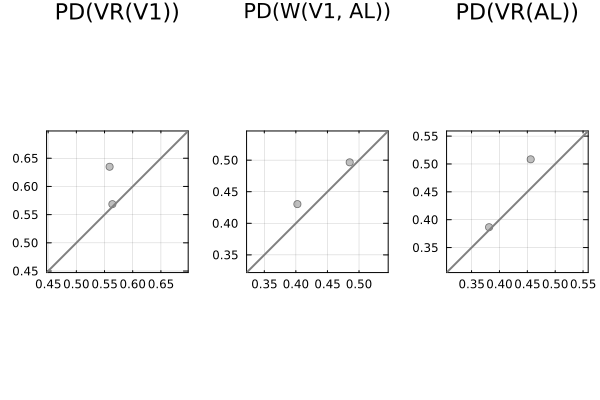

In [8]:
p1 = analogous_bars.plot_PD(barcode_V1, title = "PD(VR(V1))", titlefontsize = 15)
p2 = analogous_bars.plot_PD(barcode_W_V1_AL, title = "PD(W(V1, AL))")
p3 = analogous_bars.plot_PD(barcode_AL, title = "PD(VR(AL))", titlefontsize = 15)
plot(p1, p2, p3, layout = grid(1,3))

# Compute null model stats

In [ ]:
start_idx = collect(1:5:200)
for idx in start_idx
    shuffles = collect(idx:idx+4) 
    t = @distributed for k in shuffles
        output_filename = "null_model_stats/" * string(k)
        _, _, _, _, _ = analogous_stats.compute_analogous_bars_null_model(;
                                                                    VR_P = C_V1,
                                                                    D_P = D_V1,
                                                                    VR_Q = C_AL,
                                                                    D_Q = D_AL,
                                                                    P_null_dim = 1,
                                                                    Q_null_dim = 1,
                                                                    output_filename = output_filename
                                                                    )
    

    end
    fetch(t)
end

# Load stats

In [3]:
include("../../src/analogous_stats.jl")
using .analogous_stats

In [9]:
n_shuffles = 200
output_dir = "null_model_stats/"
selected_V1 = selected_AL = [1, 2]
stats_matrix, stats_matrix_total, selected_bar_count, no_Ftau_P_or_Q, valid_files = parse_null_model_stats(output_dir, 
                                                                         barcode_V1, 
                                                                         barcode_AL,
                                                                         selected_V1,
                                                                         selected_AL,
                                                                         n_shuffles = n_shuffles)

prob_matrix = stats_matrix ./ n_shuffles

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

In [10]:
stats_matrix_total

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0

In [11]:
stats_matrix

2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0